In [1]:
import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import os
import pandas as pd
import numpy as np
import sys
import pickle
from scipy.spatial.distance import cdist
import math
import networkx as nx
import networkx.algorithms.components.connected as nxacc
import networkx.algorithms.dag as nxadag
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import mygene
import re

In [2]:
selected_exp_gene_list = pd.read_csv("/data/common_exp_features.tsv",sep="\t")["Gene"].tolist()
selected_mut_gene_list = pd.read_csv("/data/common_mut_features.tsv",sep="\t")["Gene"].tolist()

In [3]:
def load_network(network_file_list, valid_gene_list):
    
    gene_neighbor_map = {}
    
    for file_name in network_file_list:
        
        ## print 'Load network', file_name
        
        file_handle = open(file_name)
    
        for line in file_handle:
        
            line = line.rstrip().split()
            gene1, gene2 = line[0], line[1]
        
            if gene1 not in valid_gene_list or gene2 not in valid_gene_list:
                continue
        
            if gene1 not in gene_neighbor_map:
                gene_neighbor_map[gene1] = set()
            if gene2 not in gene_neighbor_map:
                gene_neighbor_map[gene2] = set()
            
            gene_neighbor_map[gene1].add(gene2)
            gene_neighbor_map[gene2].add(gene1)
            
        file_handle.close()
    
    return gene_neighbor_map
                             
def load_name_space():
        
    go_tab_map = {}
    
    file_handle = open(go_name_space_file)
    
    for line in file_handle:
        line = line.rstrip().split()
        go_tab_map[line[0]] = line[1]
        
    file_handle.close()
    
    return go_tab_map
        
def list2index(cell_line_list, cell_line2id):
    
    cell_line_idx_list = []
    
    for cell_line in cell_line_list:
        cell_line_idx_list.append(cell_line2id[cell_line])
        
    return np.asarray(cell_line_idx_list)

In [49]:
PDTC_data_file = '/data/PTDC/'
PDTC_exp_data_file = PDTC_data_file + 'ExpressionModels.tsv'
PDTC_drug_cell_line_file = PDTC_data_file + 'DrugResponsesAUCModels.tsv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

#cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
PDTC_mutation_data_file = PDTC_data_file + 'SNVsModels.tsv'
PDTC_drug_target_file ='/data/drug_targets.tsv'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

data_file = '/data/GDSC/'
new_network_file = '/data/'

exp_data_file = data_file + 'Cell_line_RMA_proc_basalExp.txt'

drug_cell_line_file = data_file + 'v17_fitted_dose_response.csv'
#download at https://ftp.sanger.ac.uk/pub4/cancerrxgene/releases/release-6.0/v17_fitted_dose_response.xlsx

cell_line_detail_file = data_file + 'Cell_Lines_Details.csv'
mutation_data_file = data_file + 'WES_variants.csv'
drug_target_file ='/data/drug_targets.tsv'

feature_folder = 'feature/'

inbiomap_file = 'InBioMap_Symbol.sif'
pathwaycomm_file = 'PathwayCommons_Symbol.sif'

pd.set_option('display.max_columns', 20)
pd.set_option('display.max_row', 10)

In [53]:
exp_df = pd.read_csv(exp_data_file, sep='\t', index_col=0)
exp_df = exp_df.T[1:]
exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

exp_df.index = exp_df.index.map(stripNumber)
exp_df = exp_df.groupby(level=0).first()

exp_df = exp_df[selected_exp_gene_list]
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())

# # print len(exp_cell_line_list), len(exp_gene_list)

In [59]:
PDTC_exp_df = pd.read_csv(PDTC_exp_data_file, sep='\t', index_col=0).fillna(0)
PDTC_exp_df = PDTC_exp_df.T[1:]
#exp_df = exp_df.rename(columns={np.nan: 'NO_GENE_NAME'})
#exp_df = exp_df.drop('NO_GENE_NAME',axis=1)

def stripNumber(line):
    m = re.match('DATA\.([0-9]+)\.?', line)
    return int(m.group(1))

#exp_df.index = exp_df.index.map(stripNumber)
#exp_df = exp_df.groupby(level=0).first()
PDTC_exp_df = PDTC_exp_df[selected_exp_gene_list]

PDTC_exp_gene_list = list(PDTC_exp_df.columns)
PDTC_exp_cell_line_list = list(PDTC_exp_df.index.unique())

In [67]:
exp_df = pd.concat([exp_df,PDTC_exp_df])
exp_gene_list = list(exp_df.columns)
exp_cell_line_list = list(exp_df.index.unique())

In [73]:
maf = pd.read_csv(mutation_data_file, sep=',', index_col=0).fillna(0)
mutation_df = maf.groupby(['COSMIC_ID', 'Gene']).size().unstack().fillna(0)
mutation_df = mutation_df[selected_mut_gene_list]


mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())

# print len(mutation_cell_line_list), len(mutation_gene_list)
mutation_df

Gene,ABCA13,ACIN1,ADCY4,AR,ARID1B,BRD7,BZRAP1,CCDC155,CDC27,CKAP4,...,RYR3,SETD1A,SMYD5,SP8,SRRM2,SUPT6H,SYNE1,TCF20,TP53,TTN
COSMIC_ID,,,,,,,,,,,,,,,,,,,,,
683665,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
683667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
684052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1660034,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,3.0
1660035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1660036,4.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,0.0,...,7.0,0.0,1.0,0.0,0.0,0.0,9.0,2.0,2.0,28.0


In [74]:
PDTC_maf = pd.read_csv(PDTC_mutation_data_file, sep='\t', index_col=0).fillna(0)
PDTC_mutation_df= PDTC_maf.replace(to_replace="NO",value=0.0)
PDTC_mutation_df= PDTC_mutation_df.replace(to_replace="chr*",value=1.0,regex=True)
# print len(mutation_cell_line_list), len(mutation_gene_list)
PDTC_mutation_df = PDTC_mutation_df.transpose()
PDTC_mutation_df = PDTC_mutation_df[selected_mut_gene_list]
PDTC_mutation_gene_list = list(PDTC_mutation_df.columns)
PDTC_mutation_cell_line_list = list(PDTC_mutation_df.index.unique())
PDTC_mutation_df

Symbol,ABCA13,ACIN1,ADCY4,AR,ARID1B,BRD7,BZRAP1,CCDC155,CDC27,CKAP4,...,RYR3,SETD1A,SMYD5,SP8,SRRM2,SUPT6H,SYNE1,TCF20,TP53,TTN
AB521M,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
AB551,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
AB555,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AB559,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
AB580,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO102,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
VHIO124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
VHIO131IGFRES,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
VHIO179,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [75]:
mutation_df = pd.concat([mutation_df,PDTC_mutation_df])
mutation_gene_list = list(mutation_df.columns)
mutation_cell_line_list = list(mutation_df.index.unique())

In [76]:
mutation_df

,ABCA13,ACIN1,ADCY4,AR,ARID1B,BRD7,BZRAP1,CCDC155,CDC27,CKAP4,...,RYR3,SETD1A,SMYD5,SP8,SRRM2,SUPT6H,SYNE1,TCF20,TP53,TTN
683665,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
683667,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
684052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VHIO102,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
VHIO124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
VHIO131IGFRES,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
VHIO179,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [77]:
file_handle = open(drug_target_file)

drug_target_map = {}
drug_target_list = []
for line in file_handle:
    
    new_line = line.rstrip().split("\t")
    drug = new_line[0]
    target_list=new_line[1].split(',')
    if drug != "Drug":
        target_list_str = ""
        for i in range(0,len(target_list)):
            if i == len(target_list) - 1:
                target_list_str += target_list[i].replace('"','')
            else:
                target_list_str += target_list[i].replace('"','') + ","
        drug = drug.strip()

        drug_target_map[drug] = []
        if ',' not in target_list_str:
            drug_target_map[drug].append(target_list_str.strip())
            drug_target_list.append(target_list_str.strip())
        else:
            target_list = target_list_str.split(',')
            for target in target_list:
                drug_target_map[drug].append(target.strip())
                drug_target_list.append(target.strip())

# print len(drug_target_list)
# print drug_target_map

In [82]:
drugs_legend = pd.read_csv('/data/GDSC/Screened_Compounds.csv', sep=',', index_col=0)

drug2id_mapping = {}

for index in list(drugs_legend.index) :
    drug_name = drugs_legend.loc[index,'Drug Name']
    drug2id_mapping[ drug_name ] = index

In [83]:
valid_gene_list = list(set(drug_target_list) | set(exp_gene_list) | set(mutation_gene_list))

In [84]:
network_list = [new_network_file+inbiomap_file, new_network_file+pathwaycomm_file]
gene_neighbor_map =  load_network(network_list, valid_gene_list)

In [85]:
gene_name_df = pd.read_table('/data/HUGO_protein-coding_gene.tsv',index_col=25, sep='\t')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (31,38) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [86]:
gene_name_map = {}

for uniprot_gene in gene_name_df.index:
    ## print uniprot_gene
    if isinstance(uniprot_gene, type('aaa')) == False:
        continue
    
    if isinstance(gene_name_df.loc[uniprot_gene, 'symbol'], type('aaa')) == False:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol'][0]
    else:
        gene_name_map[uniprot_gene] = gene_name_df.loc[uniprot_gene, 'symbol']

In [87]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

uniprot_gene_set = set()

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
        
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    for gene in complex_list:
        uniprot_gene_set.add(gene)

# print len(uniprot_gene_set), 'genes'

query_gene_set = []

for gene in uniprot_gene_set:
    if gene not in gene_name_map:
        query_gene_set.append(gene)
    
# print 'Need to query', len(query_gene_set)

query_gene_list = list(query_gene_set)

mg = mygene.MyGeneInfo()
out = mg.querymany(query_gene_list, scopes='uniprot', fields='symbol', species='human')

not_found_gene_list = []

for i, gene in enumerate(query_gene_list):
    if 'notfound' in out[i]:
        not_found_gene_list.append(gene)
    else:
        gene_name_map[gene] = out[i]['symbol']
        
# print len(not_found_gene_list), 'symbol name not found', len(gene_name_map)

querying 1-43...done.
Finished.
1 input query terms found dup hits:
	[('P01871', 2)]
26 input query terms found no hit:
	['Q13791', 'Q95114', 'P62861', 'Q8R3P7', 'Q13745', 'O15320', 'Q16198', 'A1Z199', 'Q9Y2S0', 'Q0VAK7',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [88]:
corum_df = pd.read_table(new_network_file + 'allComplexes.txt', index_col=0)

for index in corum_df.index:
    
    if corum_df.loc[index, 'Organism'] != 'Human':
        continue
    
    complex_list = corum_df.loc[index, 'subunits(UniProt IDs)'].split(';')
    
    complex_symbol_list = []
    
    for gene in complex_list:
        if gene in gene_name_map:
            complex_symbol_list.append( gene_name_map[gene] )

    for gene1, gene2 in itertools.combinations(complex_symbol_list,2):
        
        if gene1 not in gene_neighbor_map:
            gene_neighbor_map[gene1] = set()
        if gene2 not in gene_neighbor_map:
            gene_neighbor_map[gene2] = set()
        
        gene_neighbor_map[gene1].add(gene2)
        gene_neighbor_map[gene2].add(gene1)

In [89]:
gene_exp_neighbor_map = {}
exp_matrix = exp_df.values

P = 1 - cdist(np.transpose(exp_matrix), np.transpose(exp_matrix),'correlation')

for i in range(len(exp_gene_list)):
    
    gene1 = exp_gene_list[i]
    gene_exp_neighbor_map[gene1] = set()
    
    for j in range(len(exp_gene_list)):
        
        gene2 = exp_gene_list[j]
        
        if math.fabs(P[i, j]) > 0.4:
            gene_exp_neighbor_map[gene1].add(gene2)
            
    if gene1 not in gene_exp_neighbor_map[gene1]:
        print (gene1, 'not in itself?', P[i,i])

In [97]:
selected_drugs = pd.read_csv("/code/priority_drugs.txt",names=["Drug"])
selected_drugs = selected_drugs["Drug"].tolist()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

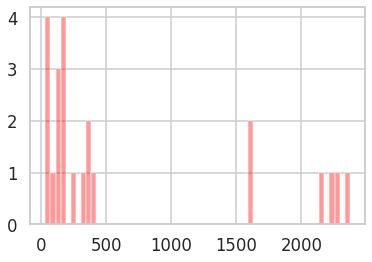

In [98]:
drug_feature_list = []
drug_neighbor_map = {}
selected_drug_list = []

for drug, target_list in drug_target_map.items():
    if drug in selected_drugs:
        drug_neighbor_map[drug] = set()

        for gene in target_list:

            if gene not in gene_exp_neighbor_map and gene not in gene_neighbor_map:
                continue

            if gene in gene_exp_neighbor_map:
                drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_exp_neighbor_map[gene]

            if gene in gene_neighbor_map:
                drug_neighbor_map[drug] = drug_neighbor_map[drug] | gene_neighbor_map[gene]

        if len(drug_neighbor_map[drug]) != 0:
             selected_drug_list.append(drug)
             drug_feature_list.append( len(drug_neighbor_map[drug]) )
sns.set_style("whitegrid")
sns.set_context("talk")
sns.distplot(drug_feature_list,color='r',bins=60,kde=False,norm_hist=False)

In [ ]:
drug2id_mapping

In [111]:
drugs = pd.read_csv(drug_cell_line_file,index_col=2)
drugs = drugs.drop(["DATASET_VERSION","IC50_RESULTS_ID","MAX_CONC_MICROMOLAR","RMSE"],axis=1)
drugs_cell_line_list = list(drugs.index.unique())
# print len(drugs_cell_line_list)
drug_list = drugs["DRUG_ID
new_drug_id = []
for i in drug_list:
    
    new_drug_id.append(drug2id_mapping[i])
#cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == 1026]
#cell_line_drug_matrix.loc[[924100,910924],'LN_IC50'].values
drugs
#cell_line_drug_matrix.loc[ [909758, 924247, 924107],'DRUG_ID' ]

,DRUG_ID,LN_IC50,AUC
COSMIC_ID,,,
924100,1026,0.717722,0.899410
924100,1028,2.664100,0.957206
924100,1029,3.336828,0.973893
924100,1030,5.164909,0.977844
924100,1031,-4.325309,0.508180
...,...,...,...
909907,1053,1.282224,0.809102
909907,1054,5.480756,0.982976
909907,1057,-0.138981,0.904217


In [125]:
PDTC_drugs = pd.read_csv(PDTC_drug_cell_line_file,sep='\t',index_col=0)
PDTC_drugs_cell_line_list = list(PDTC_drugs.index.unique())
# print len(drugs_cell_line_list)
drug_list = PDTC_drugs["Drug"].tolist()
new_drug_id = []
for i in drug_list:
    if i in drug2id_mapping.keys():
        new_drug_id.append(drug2id_mapping[i])
    else:
        new_drug_id.append(0)
PDTC_drugs["DRUG_ID"] = new_drug_id
PDTC_drugs["LN_IC50"] = np.log(PDTC_drugs["iC50"])
PDTC_drugs = PDTC_drugs.drop(["Drug","iC50","D1_CONC","D5_CONC","perc.iC50"],axis=1)

In [126]:
PDTC_drugs

,AUC,DRUG_ID,LN_IC50
Model,,,
HCI001,0.217813,1242,1.701702
HCI001,0.301919,0,9.817371
HCI001,0.494210,179,0.300300
HCI001,0.102932,1046,5.024708
HCI001,0.497307,0,-2.082194
...,...,...,...
VHIO244,0.560835,1012,-0.737469
VHIO244,0.080441,0,11.545655
VHIO244,0.216032,0,2.162278


In [127]:
drugs = pd.concat([drugs,PDTC_drugs])

In [130]:
drugs
drugs_cell_line_list = list(drugs.index.unique())

In [131]:
cell_line_list = list(set(drugs_cell_line_list)&set(exp_cell_line_list)&set(mutation_cell_line_list) )
print(len(cell_line_list))

981


In [146]:
cell_line_legend = pd.read_csv(cell_line_detail_file, index_col=1)
PDTC_cell_line = pd.DataFrame({'Line': ["BRCA"]*len(PDTC_exp_cell_line_list), 'Site':["PDTC"]*len(PDTC_exp_cell_line_list),"Histology":["breast"]*len(PDTC_exp_cell_line_list)},index=PDTC_exp_cell_line_list)
cell_line_legend = pd.concat([cell_line_legend,PDTC_cell_line])
## print cell_line_legend

tissue_map = {}

for cell_line in cell_line_list:
    
    tissue = cell_line_legend.loc[cell_line,'Site']
    
    if tissue not in tissue_map:
        tissue_map[tissue] = []
        
    tissue_map[tissue].append(cell_line)

large_tissue_number = 0
for tissue, cell_line in tissue_map.items():
    
    if len(cell_line) >= 15:
        large_tissue_number += 1
    
    print (tissue, len(cell_line))

print('How many tissues', len(tissue_map))
print('Large tissues', large_tissue_number)

'''
file_handle = open(data_file + "sanger_tissue_cell_line_list.pkl","wb")
pickle.dump(tissue_map,file_handle)
file_handle.close()
'''

haematopoietic_and_lymphoid_tissue 163
central_nervous_system 56
stomach 28
bone 40
pancreas 32
large_intestine 48
lung 169
PDTC 19
soft_tissue 22
urinary_tract 19
autonomic_ganglia 29
oesophagus 35
upper_aerodigestive_tract 42
ovary 41
breast 50
cervix 13
endometrium 11
thyroid 15
skin 55
liver 16
adrenal_gland 1
vulva 3
prostate 7
biliary_tract 5
kidney 31
salivary_gland 2
pleura 21
NS 3
testis 2
placenta 2
small_intestine 1
How many tissues 31
Large tissues 20


'\nfile_handle = open(data_file + "sanger_tissue_cell_line_list.pkl","wb")\npickle.dump(tissue_map,file_handle)\nfile_handle.close()\n'

In [147]:
len(valid_gene_list)

3147

In [148]:
new_exp_gene_list = []
for i in exp_gene_list:
    if i in valid_gene_list:
        new_exp_gene_list.append(i)

In [150]:
exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

# print np.sum(exp_stdev > exp_perc), np.sum(mut_sum > 5)#, np.sum(cnv_stdev > cnv_perc)

#new_exp_df = exp_df.loc[ cell_line_list, list(filtered_exp_gene_list) ]
#new_mutation_df = mutation_df.loc[ cell_line_list, list(filtered_mut_gene_list) ]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

In [151]:
len(filtered_exp_gene_list)

2715

In [152]:
rename_selected_drug_list = []
temp = ["Sorafenib"]
for drug in temp:
#     if drug != 'Nutlin-3a (-)':
#         continue
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
    else:
        cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]
    

        ## print cell_line_drug_matrix

        feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
        feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
        print(len(feature_exp_gene_list) + len(feature_mut_gene_list))
        if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
            continue
        feature_description = []

        drug_tissue_map = {}

        drug = drug.replace(' ','_')

        rename_selected_drug_list.append(drug)

        # print drug
        if drug == 'Nutlin-3a_(-)':
            drug = 'Nutlin-3a'

        drug_folder = '/data/drug_feature/' + drug + '/'
        if not os.path.exists(drug_folder):
            os.makedirs(drug_folder)

        # print 'Generate features', drug

        for tissue, tissue_cell_line_list in tissue_map.items():

            drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
            drug_specific_cell_line = list(drug_specific_cell_line)
            drug_tissue_map[tissue] = drug_specific_cell_line

            feature_list = []

            if len(feature_exp_gene_list) != 0:
                feature_list.append(new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values)
                #for gene in feature_exp_gene_list:
                    #feature_description.append(gene+'_expression')

            if len(feature_mut_gene_list) != 0:
                feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
                #for gene in feature_mut_gene_list:
                    #feature_description.append(gene+'_mutation')

            feature = np.concatenate(feature_list, axis=1)

43


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 28 and the array at index 1 has size 14

In [153]:
new_data_file = ''

# print mutation_df.shape, exp_df.shape

exp_stdev = np.std(exp_df.values, axis=0)
exp_perc = np.percentile(exp_stdev,10)
filtered_exp_gene_list = np.asarray(exp_gene_list)[exp_stdev > exp_perc]

mut_sum = np.sum(mutation_df.values,axis=0)
filtered_mut_gene_list = np.asarray(mutation_gene_list)[mut_sum > 5]

# print np.sum(exp_stdev > exp_perc), np.sum(mut_sum > 5)#, np.sum(cnv_stdev > cnv_perc)

#new_exp_df = exp_df.loc[ cell_line_list, list(filtered_exp_gene_list) ]
#new_mutation_df = mutation_df.loc[ cell_line_list, list(filtered_mut_gene_list) ]

new_exp_df = exp_df.loc[ :, list(filtered_exp_gene_list) ]
new_mutation_df = mutation_df.loc[ :, list(filtered_mut_gene_list) ]

#cell_line2id = dict(zip(cell_line_list, range(len(cell_line_list))))

rename_selected_drug_list = []

for drug in selected_drug_list:
    print(drug)
#     if drug != 'Nutlin-3a (-)':
#         continue
    
    if drug not in drug2id_mapping:
        print('drug name wrong', drug)
    else:
        cell_line_drug_matrix = drugs.loc[drugs['DRUG_ID'] == drug2id_mapping[drug]]

        ## print cell_line_drug_matrix
        #these control the second dim of the file, need to make these the same 
        
        feature_exp_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_exp_gene_list) )
        feature_mut_gene_list = list( set(drug_neighbor_map[drug]) & set(filtered_mut_gene_list) )
        print(len(feature_exp_gene_list) + len(feature_mut_gene_list))
        if len(feature_exp_gene_list) + len(feature_mut_gene_list) == 0:
            continue
        feature_description = []

        drug_tissue_map = {}

        drug = drug.replace(' ','_')

        rename_selected_drug_list.append(drug)

        # print drug
        if drug == 'Nutlin-3a_(-)':
            drug = 'Nutlin-3a'

        drug_folder = '/data/PDTC/drug_feature/' + drug + '/'
        if not os.path.exists(drug_folder):
            os.makedirs(drug_folder)

        # print 'Generate features', drug

        for tissue, tissue_cell_line_list in tissue_map.items():

            drug_specific_cell_line = set( cell_line_drug_matrix.index ) & set( tissue_cell_line_list )
            drug_specific_cell_line = list(drug_specific_cell_line)
            drug_tissue_map[tissue] = drug_specific_cell_line

            feature_list = []

            if len(feature_exp_gene_list) != 0:
                feature_list.append( new_exp_df.loc[ drug_specific_cell_line, feature_exp_gene_list ].values )
                for gene in feature_exp_gene_list:
                    feature_description.append(gene+'_expression')

            if len(feature_mut_gene_list) != 0:
                feature_list.append( mutation_df.loc[ drug_specific_cell_line, feature_mut_gene_list ].values )
                for gene in feature_mut_gene_list:
                    feature_description.append(gene+'_mutation')

            feature = np.concatenate(feature_list, axis=1)

            label = cell_line_drug_matrix.loc[ drug_specific_cell_line,'LN_IC50'].values

            #label = new_crispr_df.loc[ tissue_cell_line_list, label_gene ].values

            # print feature.shape, label.shape

            np.save(drug_folder + tissue + '_' + drug + '_feature.npy', feature )
            np.save(drug_folder + tissue + '_' + drug + '_label.npy', label)
            np.save(drug_folder + tissue + '_feature_description.npy', np.asarray(feature_description))

        file_handle = open("/data/PDTC/" + drug+'_tissue_cell_line_list.pkl',"wb")
        pickle.dump(drug_tissue_map,file_handle)
        file_handle.close()
    
file_handle = open('rename_selected_drug_list', 'w')
for drug in rename_selected_drug_list:
    file_handle.writelines(drug+ '\n')
file_handle.close()


681640
155


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 38 and the array at index 1 has size 19

In [136]:
len(drug_neighbor_map["AZ628"])

51

In [86]:
len(drug_tissue_map['breast'])

14

In [87]:
import pickle

In [37]:
cell_line_loc = '/cellar/users/samsonfong/Projects/tcrp-v2/from-ma/cell_line_lists/'

In [38]:
with open('/data/drug_feature/KU-55933/KU', 'rb') as f: 
    tmap= pickle.load(f)

In [48]:
tmap.keys()

['large_intestine',
 'vulva',
 'pleura',
 'endometrium',
 'lung',
 'skin',
 'autonomic_ganglia',
 'kidney',
 'thyroid',
 'cervix',
 'testis',
 'central_nervous_system',
 'oesophagus',
 'NS',
 'upper_aerodigestive_tract',
 'biliary_tract',
 'stomach',
 'soft_tissue',
 'urinary_tract',
 'liver',
 'prostate',
 'pancreas',
 'placenta',
 'adrenal_gland',
 'salivary_gland',
 'small_intestine',
 'haematopoietic_and_lymphoid_tissue',
 'ovary',
 'bone',
 'breast']

In [49]:
len(tmap['lung'])

137

In [88]:
f = np.load('/data/drug_feature/KU-55933/lung_KU-55933_feature.npy')

In [89]:
f.shape

(137, 1413)